In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_64192\667666233.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [3]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - polna luna

Preverila bom, če se ritmičnost nesreč, ki so se zgodile med polno luno, razlikuje od ritmičnosti ostalih nesreč.

In [4]:
# Maska za luno
moon_mask = (accidents_moon['moon_phase'] == 'Full Moon')

accidents_full_moon = accidents_moon[moon_mask]
# display(accidents_full_moon)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_full_moon['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsFullMoon",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

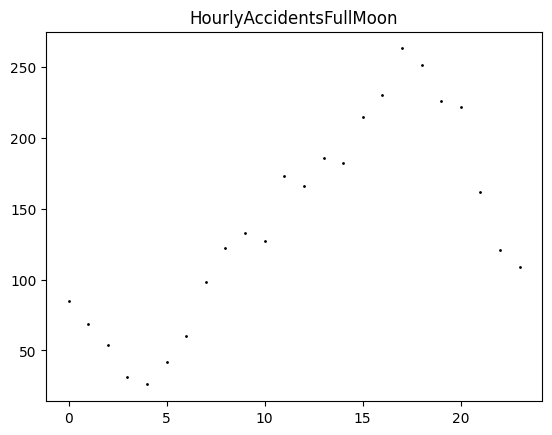

In [24]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsFullMoon"])

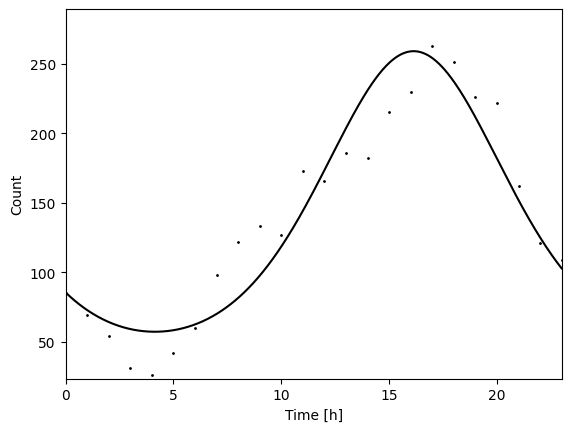

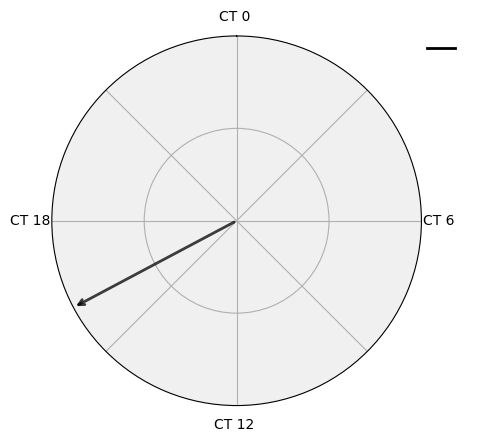

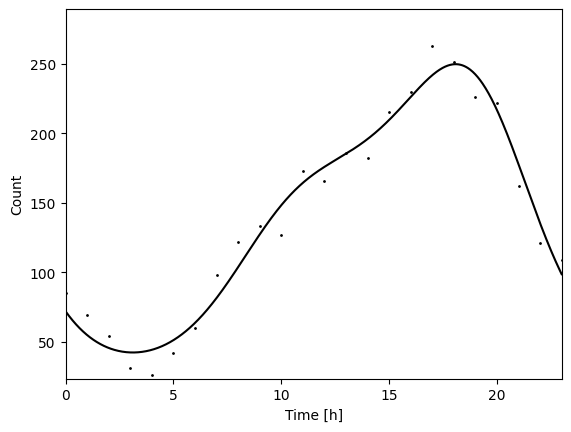

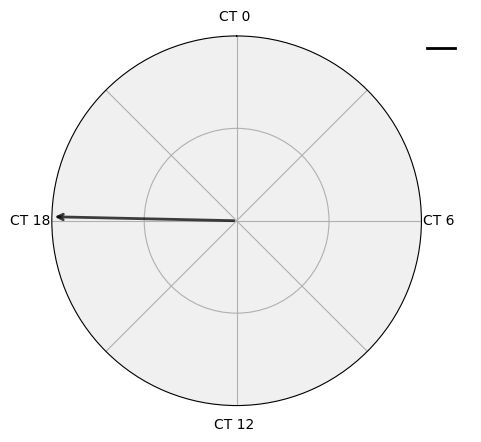

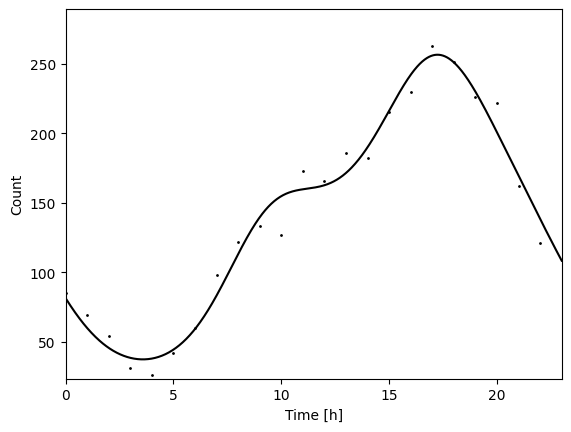

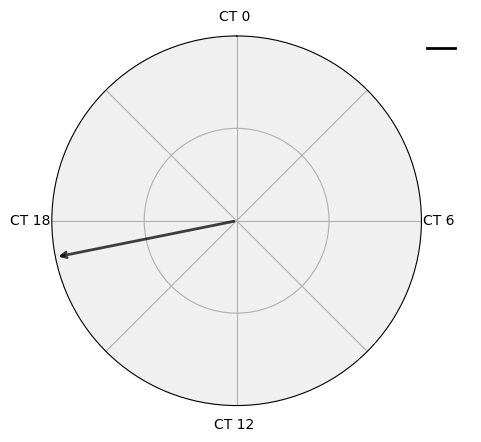

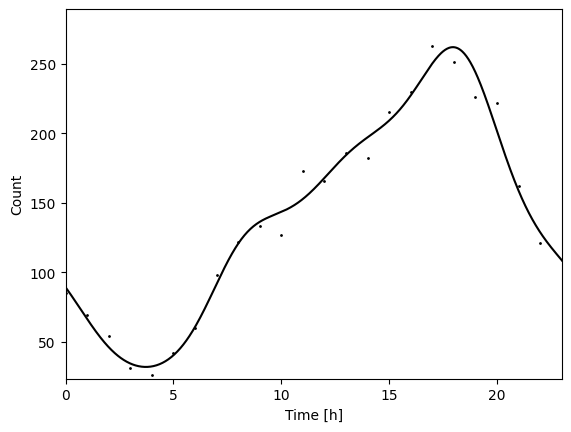

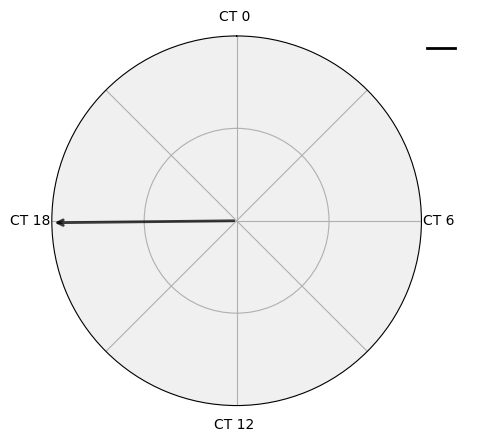

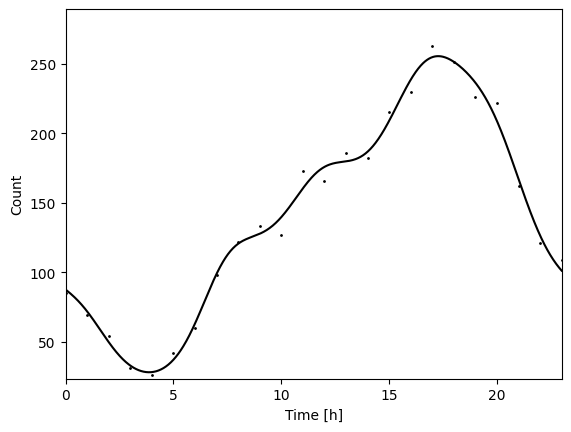

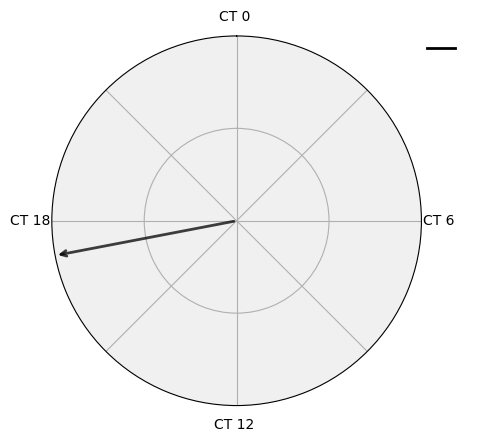

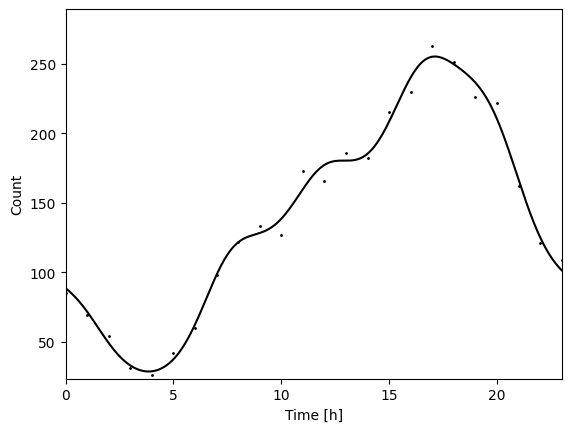

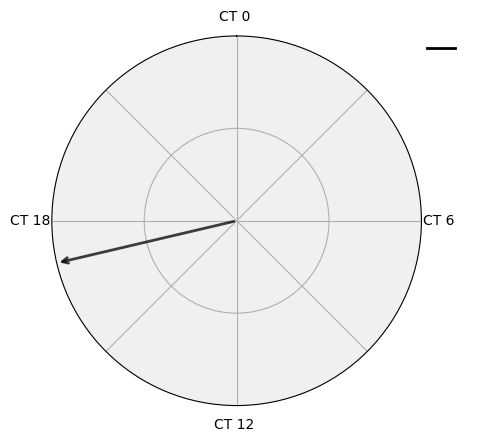

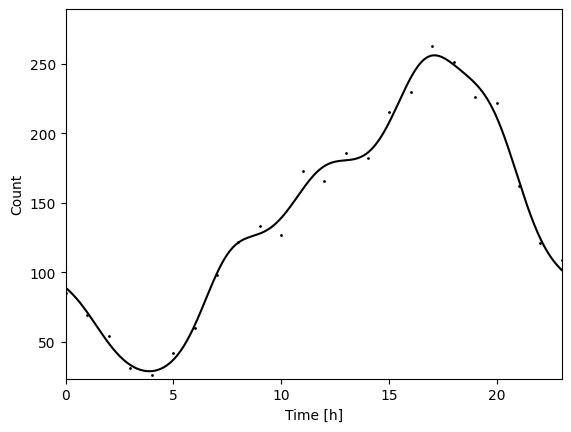

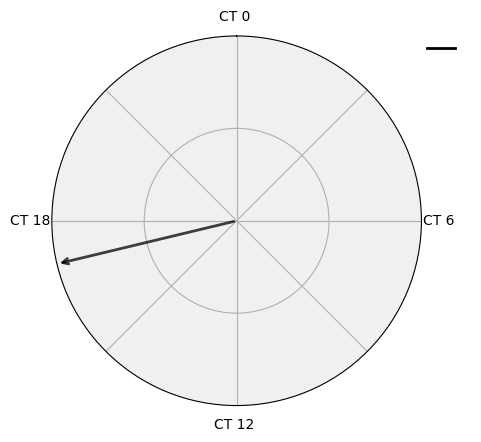

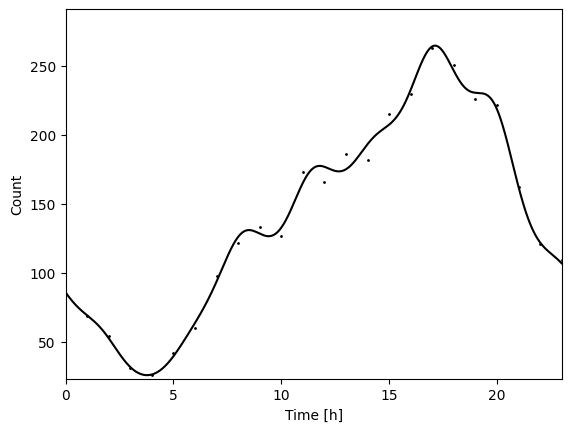

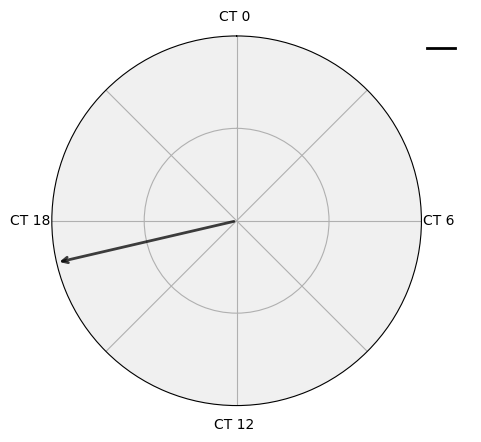

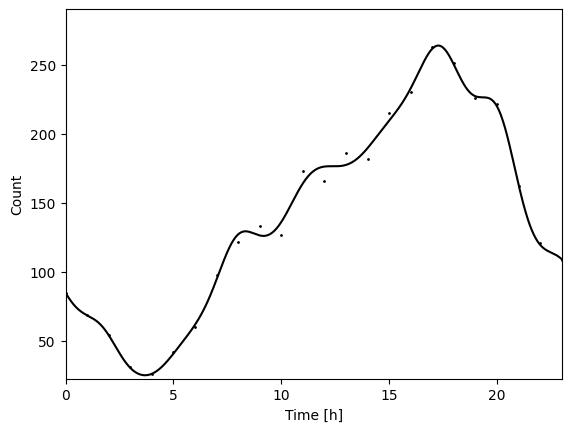

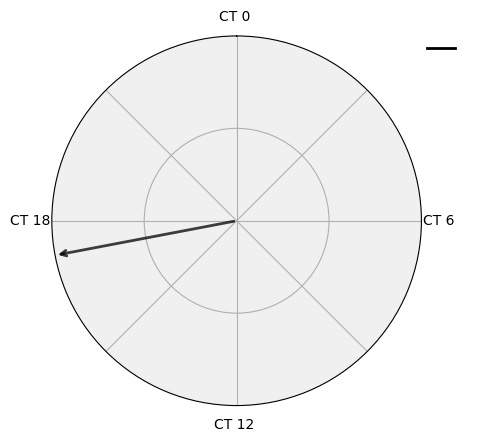

In [18]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsFullMoon', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsFullMoon', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsFullMoon',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [19]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsFullMoon,24.0,1.0,2.906292e-12,2.906292e-12,13852.442492,-111.182567,0.192848,100.924584,2.059206,158.119763,[16.134413441344137],[259.04431890009585],[4.138013801380138],[57.19518165766687],230.365133,235.077349
1,HourlyAccidentsFullMoon,24.0,2.0,1.474407e-16,1.658707e-16,3806.780534,-97.575874,0.291628,103.709181,1.548960,145.982275,[18.083408340834083],[249.6914565387509],[3.115511551155116],[42.27309398202028],207.151747,214.220070
2,HourlyAccidentsFullMoon,24.0,3.0,1.794239e-17,2.306878e-17,2967.466209,-92.199077,0.330662,109.588930,1.768894,146.905597,[17.243324332433243],[256.49452656857267],[3.5811581158115815],[37.31666713706729],200.398155,209.822586
3,HourlyAccidentsFullMoon,24.0,4.0,4.981510e-19,8.966718e-19,2244.972085,-85.467370,0.379532,115.031566,1.581636,146.911274,[17.95859585958596],[261.94284053664825],[3.720372037203721],[31.87970765192064],190.934740,202.715279
4,HourlyAccidentsFullMoon,24.0,5.0,6.298901e-21,2.006608e-20,1160.278707,-77.981096,0.433881,113.705274,1.760096,141.763657,[17.276927692769277],[255.46890142577766],[3.8691869186918697],[28.05838267792798],179.962191,194.098837
5,HourlyAccidentsFullMoon,24.0,6.0,6.289389e-20,1.415113e-19,1136.550055,-77.765781,0.435444,113.300930,1.801569,141.905485,"[12.831683168316832, 17.11851185118512]","[180.31070306347766, 255.20638342059644]",[3.8451845184518456],[28.604579239861216],183.531562,200.024316
6,HourlyAccidentsFullMoon,24.0,7.0,6.060775e-19,9.091162e-19,1095.223458,-77.705149,0.435884,113.639915,1.806596,142.433223,[17.0993099309931],[256.07313867885654],[3.878787878787879],[28.79331315298133],187.410299,206.259160
7,HourlyAccidentsFullMoon,24.0,8.0,5.758930e-21,2.006608e-20,662.137673,-70.056409,0.491411,119.500091,1.799056,145.338035,"[11.775577557755776, 17.12811281128113]","[177.62276518470068, 264.8381255069885]","[3.7731773177317733, 9.40894089408941]","[25.83794409631018, 126.61486194268672]",176.112819,197.317788
8,HourlyAccidentsFullMoon,24.0,9.0,6.688692e-21,2.006608e-20,537.830863,-67.795635,0.507824,119.421898,1.758839,144.575605,"[12.279627962796281, 17.28172817281728]","[176.57512624906295, 263.9973309975162]","[3.6771677167716774, 9.173717371737174]","[25.153750862856164, 126.09809268961207]",175.591270,199.152347


### Katero je najboljše število komponent

In [20]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model
# print(df_best_model)

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsFullMoon,24,2,1.474407e-16,3806.780534,-97.575874,0.291628,207.151747,214.22007,103.709181,1.54896,145.982275,[18.083408340834083],[249.6914565387509],[3.115511551155116],[42.27309398202028]


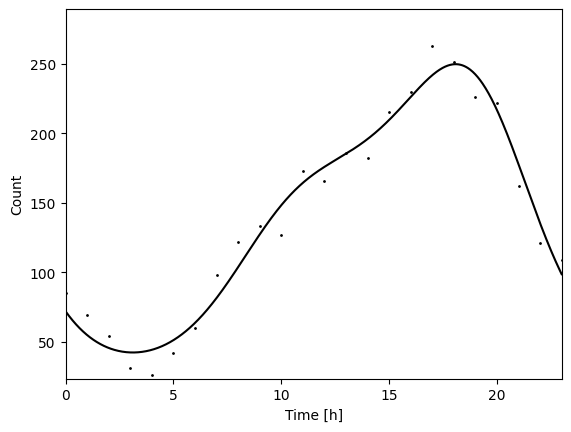

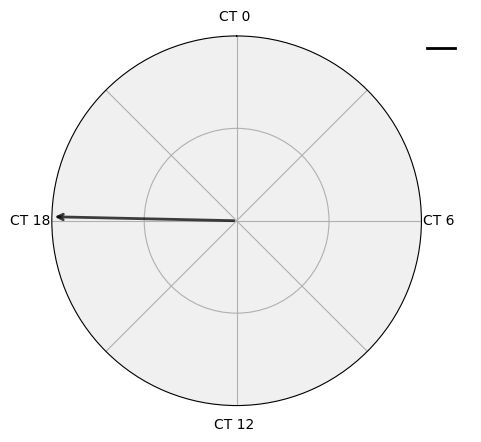

(<statsmodels.discrete.discrete_model.GeneralizedPoissonResultsWrapper at 0x1d030469a00>,
 {'p': 1.4744065498049703e-16, 'RSS': 3806.780533702031, 'count': 3353},
 {'period': 24,
  'amplitude': 103.70918127836532,
  'acrophase': 1.5489600742271907,
  'mesor': 145.9822752603856,
  'peaks': array([18.08340834]),
  'heights': array([249.69145654]),
  'troughs': array([3.11551155]),
  'heights2': array([42.27309398]),
  'max_loc': 3767,
  'period2': 24},
 array([0.00000000e+00, 4.80048005e-03, 9.60096010e-03, ...,
        4.79903990e+01, 4.79951995e+01, 4.80000000e+01]),
 array([71.8163179 , 71.71247737, 71.60886387, ..., 72.02468079,
        71.92038565, 71.8163179 ]))

In [ ]:
# cosinor.fit_me(X, Y, n_components = 2, period = 24, model_type = 'gen_poisson', save_to = "../PisanjeDiplome/angleskeSlike/kosinor-polna-luna", plot=True, plot_margins=False)
cosinor.fit_me(X, Y, n_components = 2, period = 24, model_type = 'gen_poisson', plot=True, plot_margins=False)

## RhythmCount

In [10]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsFullMoon",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [11]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

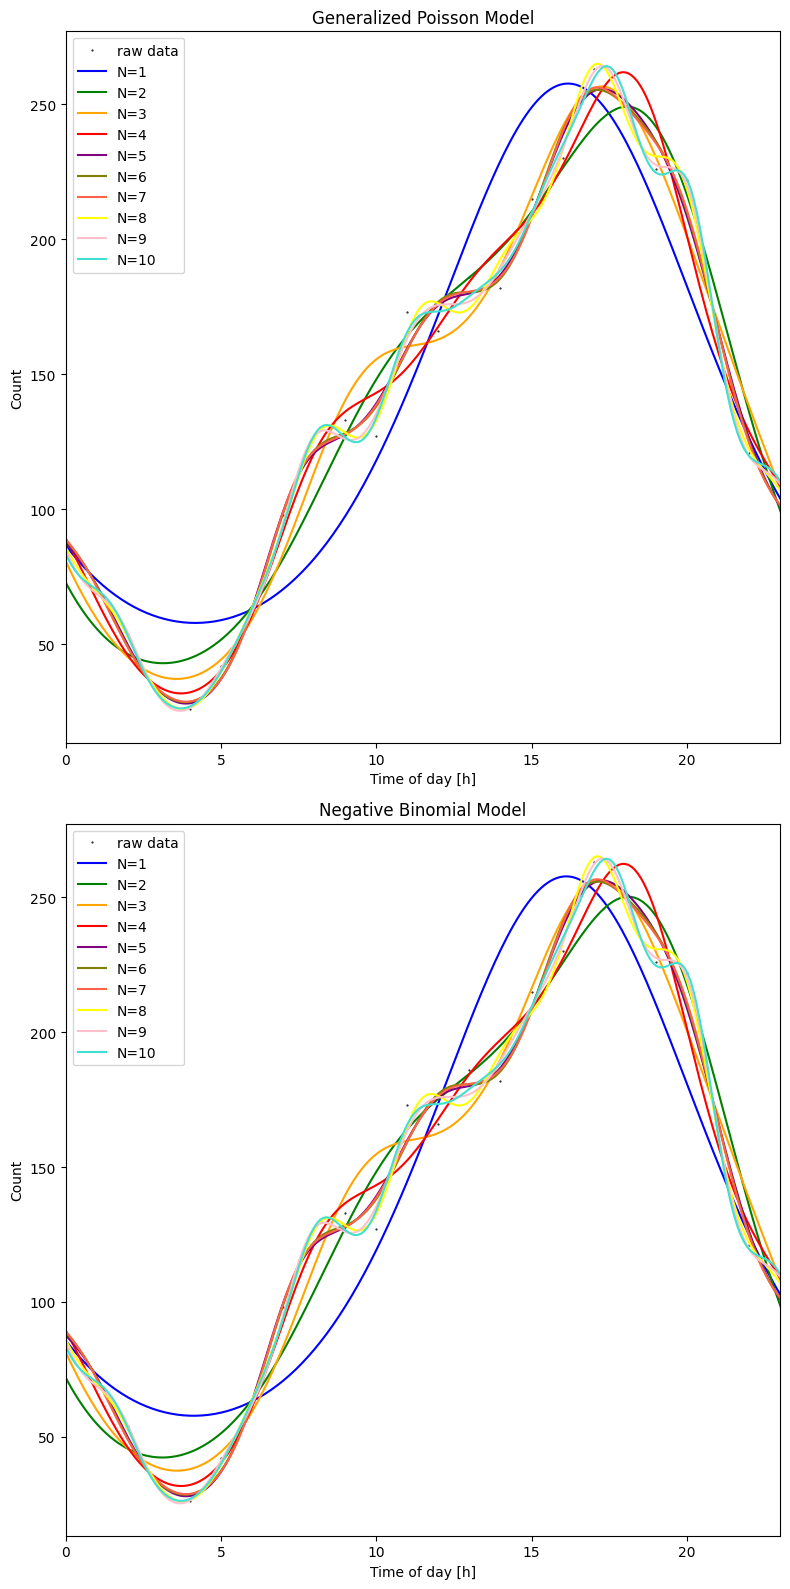

In [12]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [13]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,99.87,157.80,[16.22],[257.67],2.981896e-12,13485.279403,230.416496,235.128712,-111.208248,"[-3.9584889776742926, -3.8569694092979603, -3....",139.789179,"[86.6945234206802, 73.8893443782782, 65.171328...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[86.6945234206802, 85.21217820128712, 83.77590..."
1,gen_poisson,2,103.06,146.08,[18.12],[249.14],2.254706e-16,3818.493333,208.022539,215.090862,-98.011269,"[-4.00762262351634, -4.295914026532799, -3.513...",140.086409,"[72.97151451056352, 55.794416577869, 46.405840...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[72.97151451056352, 70.84321289269155, 68.8110..."
2,gen_poisson,3,109.70,146.89,[17.22],[256.59],2.540260e-17,2964.293487,201.124858,210.549289,-92.562429,"[-3.174663446806065, -3.8080507330330917, -3.7...",139.783763,"[80.85826829720872, 59.46473397197277, 45.2952...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[80.85826829720872, 78.42045778833237, 76.0434..."
3,gen_poisson,4,115.02,146.85,[17.92],[261.88],6.992304e-19,2246.185333,191.653472,203.434010,-85.826736,"[-3.1658801939914127, -2.9879771722667385, -3....",139.708333,"[89.28458668360047, 66.32936625630802, 45.9942...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[89.28458668360047, 87.09616237352317, 84.8673..."
4,gen_poisson,5,113.78,141.85,[17.32],[255.63],1.693242e-19,1159.096107,187.023519,201.160165,-81.511759,"[-3.08058370452693, -3.002594750627935, -3.010...",139.708333,"[87.55397014480903, 71.8576614946236, 49.80572...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[87.55397014480903, 86.29924695054866, 85.0003..."
5,gen_poisson,6,113.38,141.98,[17.12],[255.36],1.791748e-18,1135.162037,190.848501,207.341254,-81.424250,"[-3.1246034992229426, -2.99227838236375, -3.09...",139.708333,"[88.5467349765432, 71.64817784302501, 49.06074...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[88.5467349765432, 87.23905217412002, 85.86411..."
6,gen_poisson,7,113.75,142.52,[17.12],[256.27],1.676116e-17,1092.206166,194.797825,213.646686,-81.398912,"[-3.14858403830425, -2.975105490880935, -3.116...",139.708333,"[88.9908499217297, 71.26038141720201, 48.88980...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[88.9908499217297, 87.61368775672803, 86.15729..."
7,gen_poisson,8,119.49,145.55,[17.12],[265.04],1.890484e-17,658.829197,194.289363,215.494332,-79.144681,"[-3.038856142368914, -2.9282576177275814, -2.8...",139.708333,"[85.9936769275903, 69.38541369113878, 52.76902...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[85.9936769275903, 83.86338293027657, 81.83259..."
8,gen_poisson,9,119.40,144.78,[17.32],[264.18],9.680526e-17,535.869318,197.418915,220.979992,-78.709458,"[-3.0303276390661296, -2.9264487993570185, -2....",139.708333,"[85.01007591977526, 68.73624331040415, 54.3173...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[85.01007591977526, 82.47806907860833, 80.1321..."
9,gen_poisson,10,118.94,145.21,"[17.42, 19.72]","[264.15, 225.54]",5.138302e-16,435.216429,200.875789,226.792973,-78.437894,"[-3.0467199369223437, -2.9440540466662384, -2....",139.708333,"[83.41814942481862, 70.32179603961758, 53.2232...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[83.41814942481862, 81.16117274992328, 79.1638..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [14]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 5


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [15]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 5
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

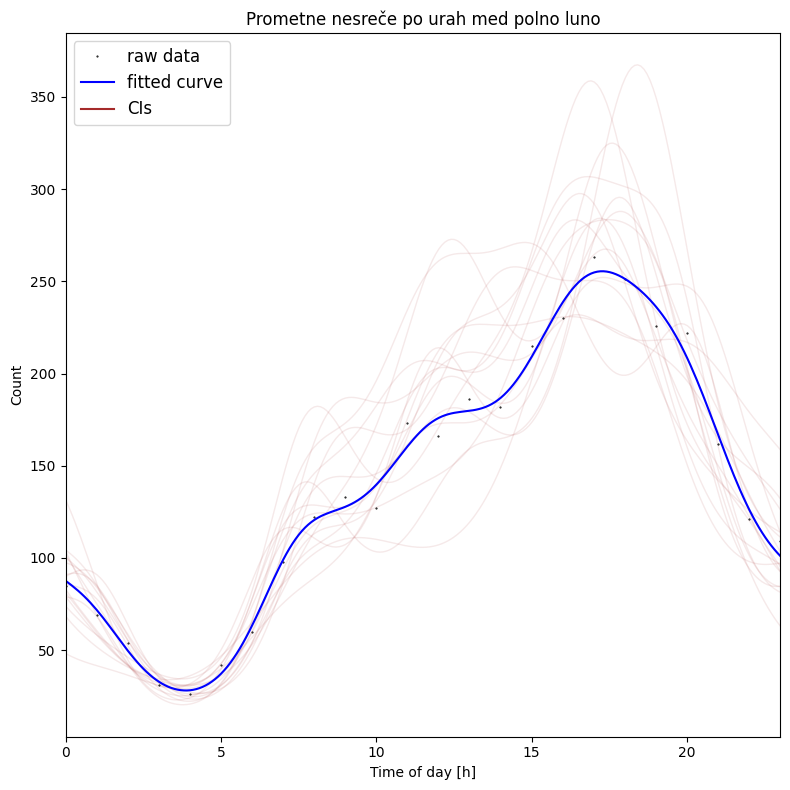

Intervali zaupanja:


,0,1
0,4.646850,4.855911
1,-0.799269,-0.655066
2,-0.659257,-0.281719
3,-0.395088,-0.177264
4,-0.175405,0.133613
5,-0.102005,0.119321
6,0.036521,0.242859
7,-0.004836,0.187990
8,0.016470,0.129199
9,-0.021544,0.115849


In [16]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah med polno luno', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [17]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,5
amplitude,113.78
mesor,141.85
peaks,[17.32]
heights,[255.63]
amplitude_CIs,"[93.61, 143.18]"
mesor_CIs,"[115.92, 177.01]"
peaks_CIs,"[16.67, 18.26]"
heights_CIs,"[239.87, 277.7]"
